In this notebook we cluster the measured target spectra for each species.

In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import feature
from yellowbrick.cluster.elbow import kelbow_visualizer

import sys, errno  


In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

warnings.filterwarnings("ignore")

In [185]:

palette = sns.color_palette(n_colors=12)
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 13
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'

In [186]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
letter_drive = 'F'
ppath = f'{letter_drive}:/AFKABAN/Pcod_190123/select/'
p2path = f'{letter_drive}:/AFKABAN/Pcod2_240123/select/'
apath = f'{letter_drive}:/AFKABAN/Acod_200123/select/'
pbpath = f'{letter_drive}:/AFKABAN/Pandalus_260123/select/'
kpath = f'{letter_drive}:/AFKABAN/Krill_270123/'

# Read saved df

In [187]:
a_df = pd.read_feather(apath+'/a_tilt_df.feather')
p_df = pd.read_feather(ppath+'/p_tilt_df.feather')
p2_df = pd.read_feather(p2path+'/p2_tilt_df.feather')
pb_df = pd.read_feather(pbpath+'/pb_tilt_df.feather')
#k_df = pd.read_feather(kpath+'/k_tilt_df.feather')

# Cluster spectra
sort by frequency bandwith

In [188]:
def select_ts_bandwidth(df):
    'Function to seperated target spectra from 120 kHz and 200 kHz echosounders'
    ind_120 = np.where(np.isnan(df['201.129']))[0]
    ts_s_120 = np.where(df.columns.values=='94.032')[0][0] #remove 5% of spectra on either side b/c ramping
    ts_e_120 = np.where(df.columns.values=='160.565')[0][0]
    
    ind_200 = np.where(np.isnan(df['120.242']))[0]
    ts_s_200 = np.where(df.columns.values=='189.032')[0][0]
    ts_e_200 = np.where(df.columns.values=='251.532')[0][0]

    df_120 = df.iloc[ind_120,ts_s_120:ts_e_120]
    df_200 = df.iloc[ind_200,ts_s_200:ts_e_200]
    
    return df_120, df_200

In [189]:
a_df_120, a_df_200 = select_ts_bandwidth(a_df)
p_df_120, p_df_200 = select_ts_bandwidth(p_df)
p2_df_120, p2_df_200 = select_ts_bandwidth(p2_df)
pb_df_120, pb_df_200 = select_ts_bandwidth(pb_df)

In [190]:
## Combine
df_120 = a_df_120.append([p_df_120])
df_200 = a_df_200.append([p_df_200])

In [191]:
df_label_120 = np.concatenate([np.zeros(len(a_df_120)),np.ones(len(p_df_120))])
df_label_200 = np.concatenate([np.zeros(len(a_df_200)),np.ones(len(p_df_200))])

### Select a df and run clustering

In [199]:
def kmean_spectra(df, num_clus=3):
    'Function to run kmean clusering on target spectra of a species'
    # Set up kmeans
    kmeans = KMeans(n_clusters=num_clus)
    
    # Normalize by the median of each target spectra
    df_norm = df.div(df.max(axis=1), axis=0)
    
    # Fit data
    y_kmean = kmeans.fit_predict(df_norm)

    return y_kmean, kmeans
    

In [219]:
num_clus=4

df_120_ykmean, k = kmean_spectra(df_120, num_clus=num_clus)



df_200_ykmean, k = kmean_spectra(df_200, num_clus=num_clus)


In [220]:
# Add kmeans group to main dataframe
def add_ykmean(df, y_120, y_200, df_f120, df_f200,num_clus):
    y_120 = pd.DataFrame(y_120, index=df_f120.index, columns=['y_kmean'])
    y_200 = pd.DataFrame(y_200+num_clus, index=df_f200.index, columns=['y_kmean'])
    y = pd.concat([y_120,y_200])
    df['y_kmean']=y
    df['abs_tilt'] = np.abs(df['tilt'])
    return df

In [221]:
a_df = add_ykmean(a_df, a_120_ykmean, a_200_ykmean, a_df_120, a_df_200,num_clus)
p_df = add_ykmean(p_df, p_120_ykmean, p_200_ykmean, p_df_120, p_df_200,num_clus)
p2_df = add_ykmean(p2_df, p2_120_ykmean, p2_200_ykmean, p2_df_120, p2_df_200,num_clus)
pb_df = add_ykmean(pb_df, pb_120_ykmean, pb_200_ykmean, pb_df_120, pb_df_200,num_clus)

### Plot kmeans clustering results

Text(0, 0.5, 'Target Strength (dB re 1m$^2$)')

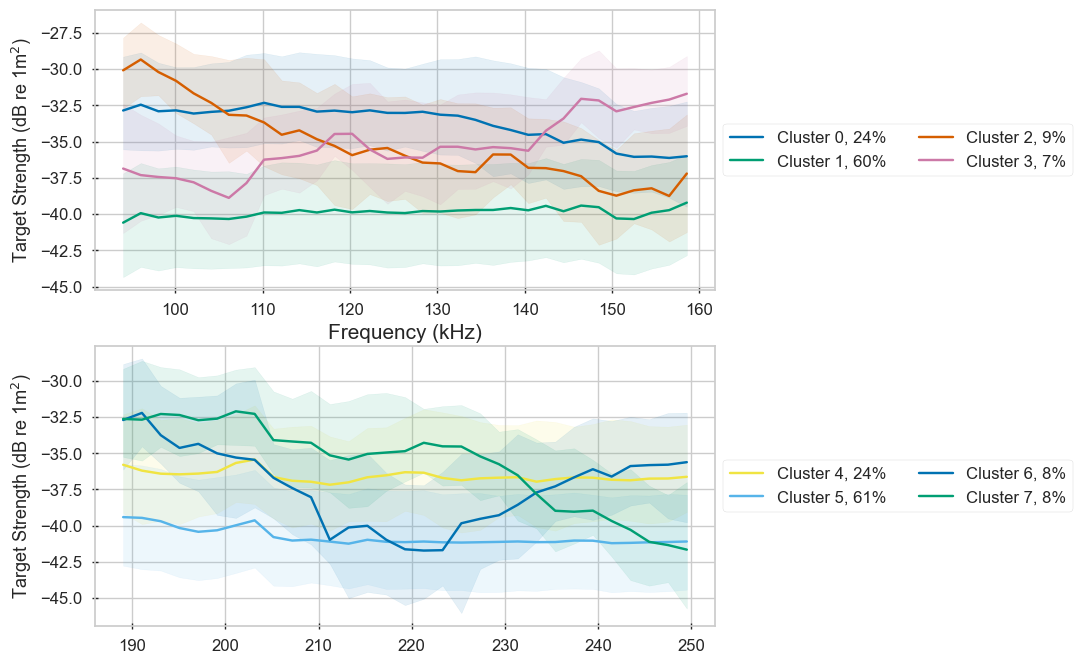

In [222]:
fig,ax = plt.subplots(2,1, figsize=(8,8))
axes = ax.flatten()


# 120 kHz
df1 = df_120
y_kmean1 = df_120_ykmean
freqs_120 = df1.columns.unique().values.astype(np.float64)

for i_cluster in range(num_clus):

    i_ts1 = np.where(y_kmean1==i_cluster)[0]
    axes[0].plot(freqs_120,np.mean(df1.iloc[i_ts1,:].T,axis=1), c=palette[i_cluster], label=f'Cluster {i_cluster:d}, {len(i_ts1)*100/len(df1):.0f}%')
    axes[0].fill_between(freqs_120,df1.iloc[i_ts1,:].quantile(q=0.25), df1.iloc[i_ts1,:].quantile(q=0.75), color=palette[i_cluster], alpha=0.1)

df2 = df_200
y_kmean2 = df_200_ykmean
freqs_200 = df2.columns.unique().values.astype(np.float64)


for i_cluster in range(num_clus):
    i_ts2 = np.where(y_kmean2==i_cluster)[0]
    axes[1].plot(freqs_200,np.mean(df2.iloc[i_ts2,:].T,axis=1), c=palette[i_cluster+num_clus], label=f'Cluster {i_cluster+num_clus:d}, {len(i_ts2)*100/len(df2):.0f}%')
    axes[1].fill_between(freqs_200,df2.iloc[i_ts2,:].quantile(q=0.25), df2.iloc[i_ts2,:].quantile(q=0.75), color=palette[i_cluster+num_clus], alpha=0.1)

axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=12, frameon=True)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=12, frameon=True)


axes[0].set_xlabel('Frequency (kHz)', fontsize=15)
axes[0].set_ylabel('Target Strength (dB re 1m$^2$)', fontsize=13)
axes[1].set_ylabel('Target Strength (dB re 1m$^2$)', fontsize=13)

#fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/PhDdocs/ConferencesMeetings/WGFAST2023/clusters.jpeg', format='jpeg', dpi = 300, facecolor='w', bbox_inches='tight')

In [223]:
palette[int(df_label_120[0])]

(0.0, 0.4470588235294118, 0.6980392156862745)

Text(0, 0.5, 'Target Strength (dB re 1m$^2$)')

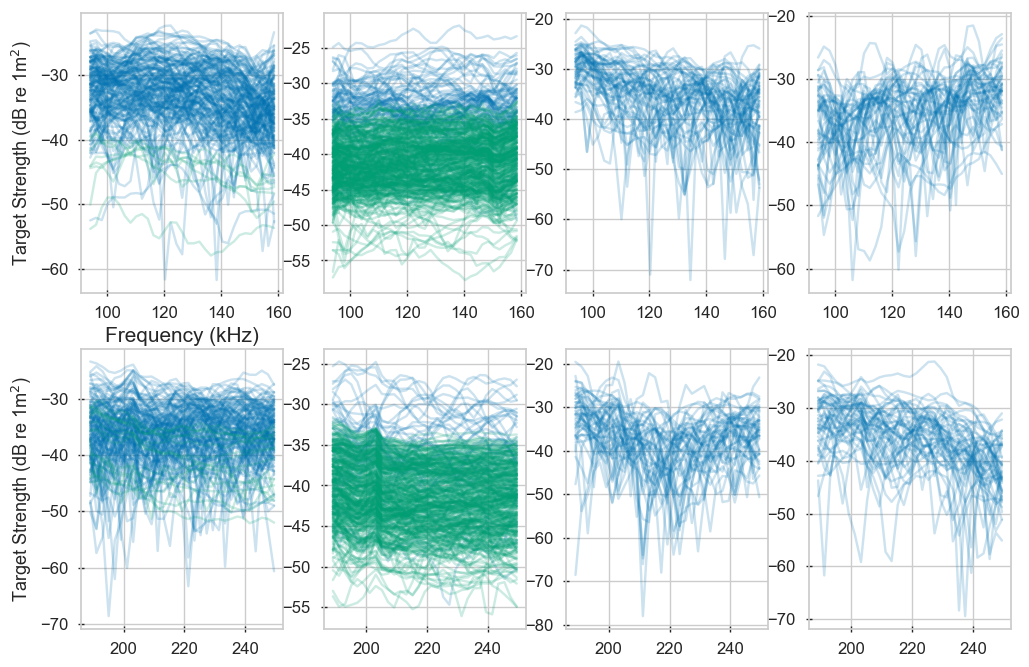

In [224]:
fig,ax = plt.subplots(2,num_clus, figsize=(12,8))


# 120 kHz
df1 = df_120
y_kmean1 = df_120_ykmean
freqs_120 = df1.columns.unique().values.astype(np.float64)

for i_cluster in range(num_clus):

    i_ts1 = np.where(y_kmean1==i_cluster)[0]
    for i in i_ts1:
        ax[0,i_cluster].plot(freqs_120,df1.iloc[i,:], c=palette[int(df_label_120[i])], alpha=0.2)
    #axes[0].fill_between(freqs_120,df1.iloc[i_ts1,:].quantile(q=0.25), df1.iloc[i_ts1,:].quantile(q=0.75), color=palette[i_cluster], alpha=0.1)

df2 = df_200
y_kmean2 = df_200_ykmean
freqs_200 = df2.columns.unique().values.astype(np.float64)


for i_cluster in range(num_clus):
    i_ts2 = np.where(y_kmean2==i_cluster)[0]
    for i in i_ts2:
        ax[1,i_cluster].plot(freqs_200,df2.iloc[i], c=palette[int(df_label_200[i])], alpha=0.2)
    #axes[1].fill_between(freqs_200,df2.iloc[i_ts2,:].quantile(q=0.25), df2.iloc[i_ts2,:].quantile(q=0.75), color=palette[i_cluster+num_clus], alpha=0.1)

axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=12, frameon=True)


ax[0,0].set_xlabel('Frequency (kHz)', fontsize=15)
ax[0,0].set_ylabel('Target Strength (dB re 1m$^2$)', fontsize=13)
ax[1,0].set_ylabel('Target Strength (dB re 1m$^2$)', fontsize=13)


## Look into the spectra that make up the clusters

In [225]:
def plot_clusterspectra(df1,df2,y_kmean1, y_kmean2, alpha=0.09):
    fig,axes = plt.subplots(2,num_clus, figsize=(12,7), sharey=True)

    # 120 kHz
    freqs_120 = df1.columns.unique().values.astype(np.float64)
    for i_cluster in range(num_clus):
        i_ts1 = np.where(y_kmean1==i_cluster)[0]
        axes[0,i_cluster].plot(freqs_120,df1.iloc[i_ts1,:].T, c='k', alpha=alpha)
        axes[0,i_cluster].set_title(f'Cluster {i_cluster:d}; {len(i_ts1)*100/len(df1):.0f}%')

    # 200 kHz
    freqs_200 = df2.columns.unique().values.astype(np.float64)
    for i_cluster in range(num_clus):
        i_ts2 = np.where(y_kmean2==i_cluster)[0]
        axes[1,i_cluster].plot(freqs_200,df2.iloc[i_ts2,:].T, c='k', alpha=alpha)
        axes[1,i_cluster].set_title(f'Cluster {i_cluster+num_clus:d}; {len(i_ts2)*100/len(df2):.0f}%')
    axes[0,0].set_ylim([-100,-20])

### Atlantic cod

# Can we correlate cluster number to tilt angle??

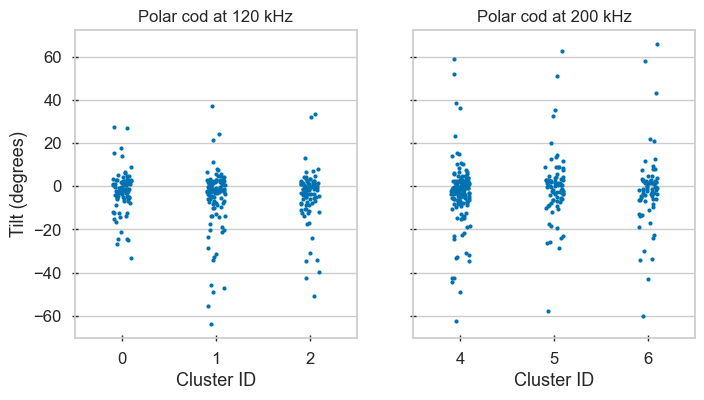

In [229]:
fig, ax = plt.subplots(1,2,figsize=(8,4), sharey=True)
axes = ax.flatten()

sns.stripplot(p_df.iloc[p_df_120.index.values,:], x='y_kmean', y='tilt', ax = axes[0], size=3)
sns.stripplot(p_df.iloc[p_df_200.index.values,:], x='y_kmean', y='tilt', ax = axes[1], size=3)

axes[0].set(title = 'Polar cod at 120 kHz', xlabel='Cluster ID', ylabel='Tilt (degrees)')
axes[1].set(title = 'Polar cod at 200 kHz', xlabel='Cluster ID', ylabel='Tilt (degrees)');

Cluster number and orientation does not seem to be related. (also tested absolute tilt angle)

Similar distributions for all species, both frequency bandwidths and each cluster.

## To off axis angle?

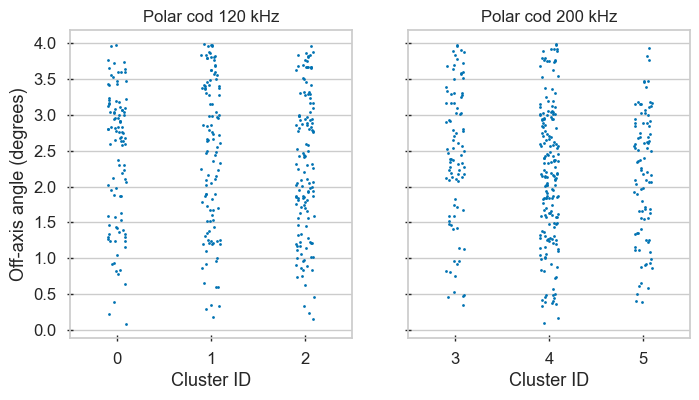

In [19]:
fig, ax = plt.subplots(1,2,figsize=(8,4), sharey=True)
axes = ax.flatten()
sns.stripplot(p_df.iloc[p_df_120.index.values,:], x='y_kmean', y='off_axis_angle', ax = axes[0], size=2)
sns.stripplot(p_df.iloc[p_df_200.index.values,:], x='y_kmean', y='off_axis_angle', ax = axes[1], size=2)

axes[0].set(title = 'Polar cod 120 kHz', xlabel='Cluster ID', ylabel='Off-axis angle (degrees)')
axes[1].set(title = 'Polar cod 200 kHz', xlabel='Cluster ID', ylabel='Off-axis angle (degrees)');

## To off axis range?

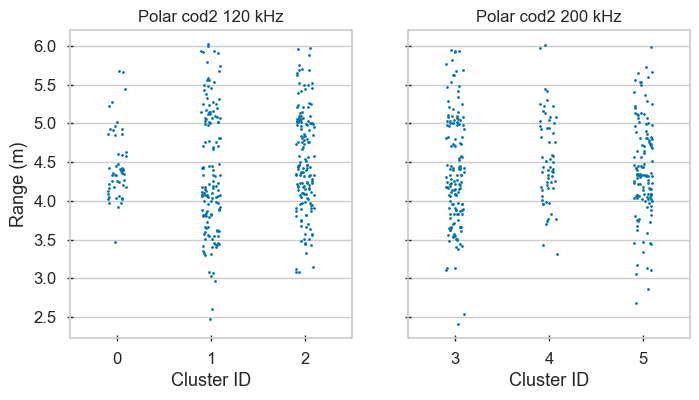

In [20]:
fig, ax = plt.subplots(1,2,figsize=(8,4), sharey=True)
axes = ax.flatten()
sns.stripplot(p2_df.iloc[p2_df_120.index.values,:], x='y_kmean', y='Target_range', ax = axes[0], size=2)
sns.stripplot(p2_df.iloc[p2_df_200.index.values,:], x='y_kmean', y='Target_range', ax = axes[1], size=2)

axes[0].set(title = 'Polar cod2 120 kHz', xlabel='Cluster ID', ylabel='Range (m)')
axes[1].set(title = 'Polar cod2 200 kHz', xlabel='Cluster ID', ylabel='Range (m)');

# Can we correlate cluster number to track number?? 
Do detection within the same track tend to be clustered together? If yes, it would show that broadband variability may be explained by individual fish length, material properties or other scattering properties that are relatively consistent for a single fish.

In [21]:
count=0

In [22]:
## Get region list for each frequency bandwidth
def select_region_bandwidth(df):
    'Function to seperated target spectra from 120 kHz and 200 kHz echosounders'
    ind_120 = np.where(np.isnan(df['201.129']))[0]
    ts_s_120 = np.where(df.columns.values=='94.032')[0][0] #remove 5% of spectra on either side b/c ramping
    ts_e_120 = np.where(df.columns.values=='160.565')[0][0]
    
    ind_200 = np.where(np.isnan(df['120.242']))[0]
    ts_s_200 = np.where(df.columns.values=='189.032')[0][0]
    ts_e_200 = np.where(df.columns.values=='251.532')[0][0]
    
    reg_120 = df['Region_name'][ind_120] 
    reg_200 = df['Region_name'][ind_200] 
    
    return reg_120, reg_200

In [23]:
a_reg_120, a_reg_200 = select_region_bandwidth(a_df)
p_reg_120, p_reg_200 = select_region_bandwidth(p_df)
p2_reg_120, p2_reg_200 = select_region_bandwidth(p2_df)
pb_reg_120, pb_reg_200 = select_region_bandwidth(pb_df)

In [24]:
# Select dataset
df_list = [a_df_120,a_df_200,p_df_120,p_df_200,p2_df_120,p2_df_200]
y_list = [a_120_ykmean,a_200_ykmean, p_120_ykmean,p_200_ykmean, p2_120_ykmean,p2_200_ykmean]
regions_list = df_list = [a_reg_120,a_reg_200,p_reg_120,p_reg_200,p2_reg_120,p2_reg_200]

select = 5
df=df_list[select]
y_kmean = y_list[select]
regions = regions_list[select]


#---------
all_regions = regions.unique()
n_cluster_track = {}
cluster_counts ={}
n_cluster_ratio = []
n_reg = []
biggest_cluster_ratio = []

count = 0
for i_reg in all_regions:
    ind_reg = np.where(regions==i_reg)[0]
    if len(ind_reg)>2:
        y_reg = y_kmean[ind_reg]

        n_cluster_track[count], cluster_counts[count] = np.unique(y_reg,return_counts=True)
        
        biggest_cluster_ratio = np.append(biggest_cluster_ratio,max(cluster_counts[count])/len(ind_reg))

        n_cluster_ratio = np.append(n_cluster_ratio,(len(n_cluster_track[count])/len(ind_reg)))
        n_reg = np.append(n_reg, len(ind_reg))
        count += 1

## Cluster number AND location in beam

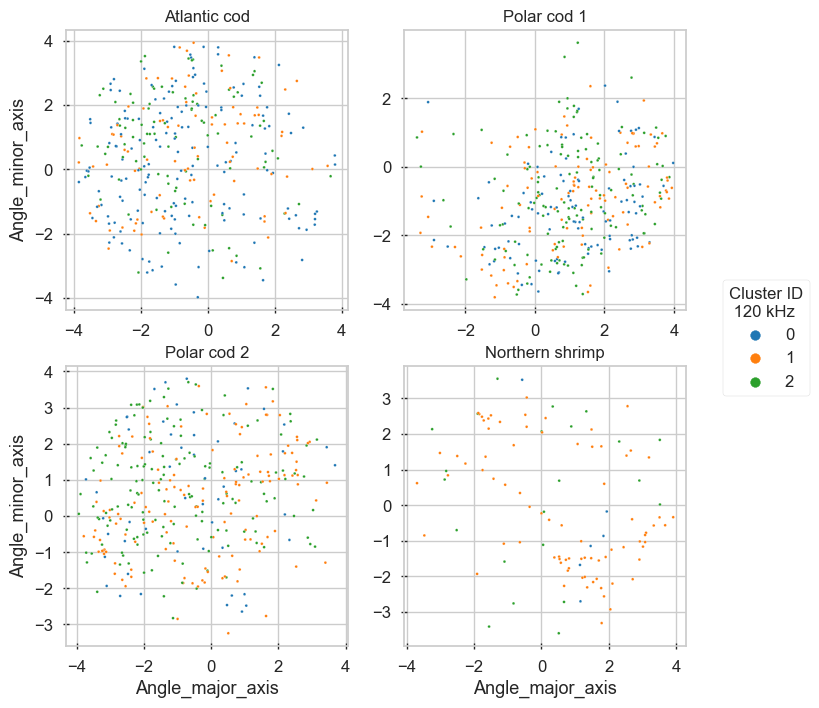

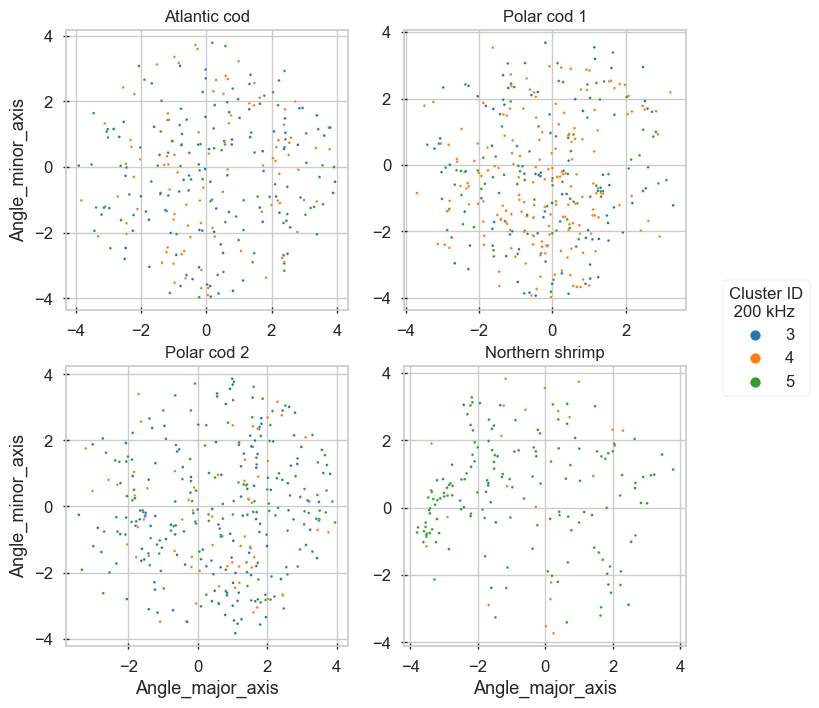

In [26]:
fig,ax = plt.subplots(2,2, figsize=(8,8))
axes = ax.flatten()
cmap = 'tab10'
# Select 120 kHz
sns.scatterplot(data = a_df[a_df['y_kmean']<num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=a_df[a_df['y_kmean']<num_clus].y_kmean, palette=cmap, s=4, ax=axes[0], legend=False)
g = sns.scatterplot(data = p_df[p_df['y_kmean']<num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=p_df[p_df['y_kmean']<num_clus].y_kmean, palette=cmap, s=4, ax=axes[1])
sns.scatterplot(data = p2_df[p2_df['y_kmean']<num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=p2_df[p2_df['y_kmean']<num_clus].y_kmean, palette=cmap, s=4, ax=axes[2], legend=False)
sns.scatterplot(data = pb_df[pb_df['y_kmean']<num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=pb_df[pb_df['y_kmean']<num_clus].y_kmean, palette=cmap, s=4, ax=axes[3], legend=False)

axes[0].set(title='Atlantic cod', xlabel='')
axes[1].set(title='Polar cod 1', xlabel='', ylabel='')
axes[2].set(title='Polar cod 2')
axes[3].set(title='Northern shrimp', ylabel='')
g.legend(title='Cluster ID\n 120 kHz',loc='center left', bbox_to_anchor=(1.1, -.1), ncol=1, fontsize=12, frameon=True)


fig,ax = plt.subplots(2,2, figsize=(8,8))
axes = ax.flatten()
cmap = 'tab10'
# Select 200 kHz
sns.scatterplot(data = a_df[a_df['y_kmean']>=num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=a_df[a_df['y_kmean']>=num_clus].y_kmean, palette=cmap, s=4, ax=axes[0], legend=False)
g = sns.scatterplot(data = p_df[p_df['y_kmean']>=num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=p_df[p_df['y_kmean']>=num_clus].y_kmean, palette=cmap, s=4, ax=axes[1])
sns.scatterplot(data = p2_df[p2_df['y_kmean']>=num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=p2_df[p2_df['y_kmean']>=num_clus].y_kmean, palette=cmap, s=4, ax=axes[2], legend=False)
sns.scatterplot(data = pb_df[pb_df['y_kmean']>=num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=pb_df[pb_df['y_kmean']>=num_clus].y_kmean, palette=cmap, s=4, ax=axes[3], legend=False)

axes[0].set(title='Atlantic cod', xlabel='')
axes[1].set(title='Polar cod 1', xlabel='', ylabel='')
axes[2].set(title='Polar cod 2')
axes[3].set(title='Northern shrimp', ylabel='')
g.legend(title='Cluster ID\n 200 kHz', loc='center left', bbox_to_anchor=(1.1, -.1), ncol=1, fontsize=12, frameon=True)

## TS and location in beam

[Text(0.5, 1.0, 'Northern shrimp'), Text(0, 0.5, '')]

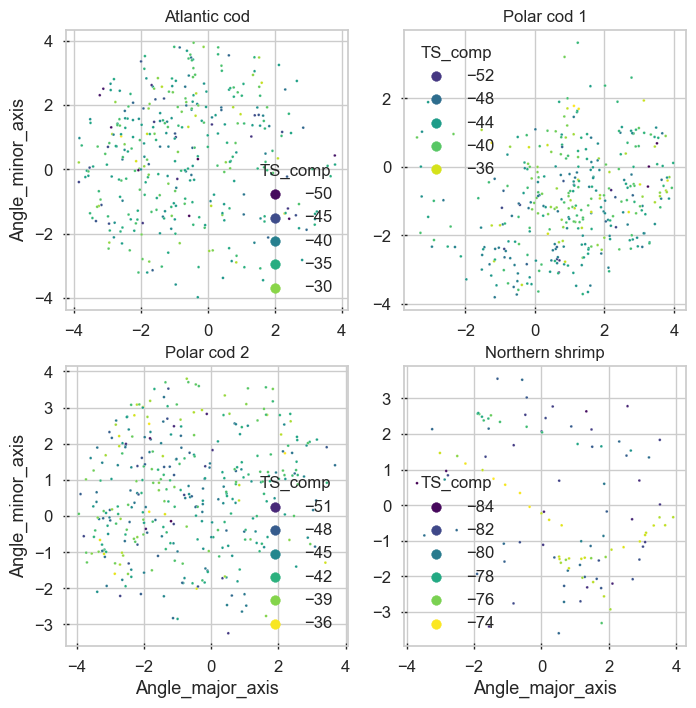

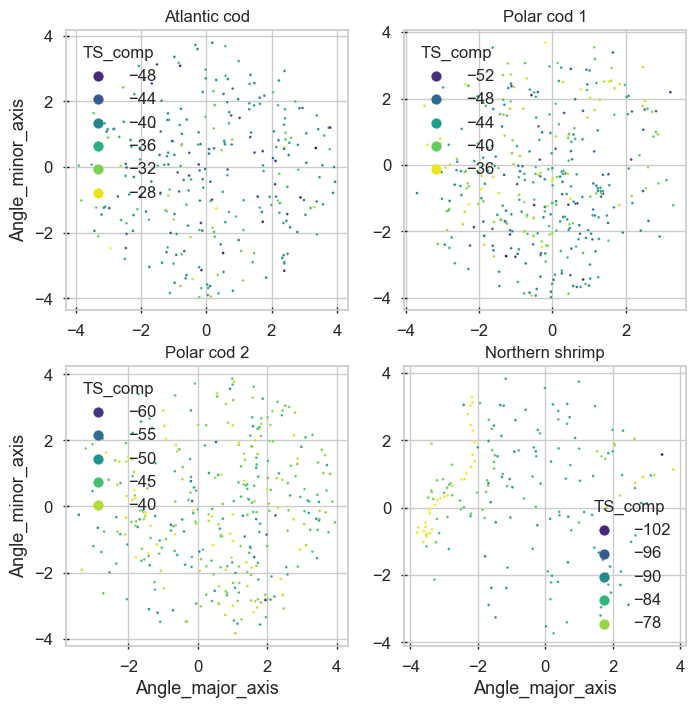

In [27]:
fig,ax = plt.subplots(2,2, figsize=(8,8))
axes = ax.flatten()
cmap = 'viridis'
# Select 120 kHz
sns.scatterplot(data = a_df[a_df['y_kmean']<num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=a_df[a_df['y_kmean']<num_clus].TS_comp, palette=cmap, s=4, ax=axes[0])
sns.scatterplot(data = p_df[p_df['y_kmean']<num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=p_df[p_df['y_kmean']<num_clus].TS_comp, palette=cmap, s=4, ax=axes[1])
sns.scatterplot(data = p2_df[p2_df['y_kmean']<num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=p2_df[p2_df['y_kmean']<num_clus].TS_comp, palette=cmap, s=4, ax=axes[2])
sns.scatterplot(data = pb_df[pb_df['y_kmean']<num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=pb_df[pb_df['y_kmean']<num_clus].TS_comp, palette=cmap, s=4, ax=axes[3])

axes[0].set(title='Atlantic cod', xlabel='')
axes[1].set(title='Polar cod 1', xlabel='', ylabel='')
axes[2].set(title='Polar cod 2')
axes[3].set(title='Northern shrimp', ylabel='')
#g.legend(title='Cluster ID\n 120 kHz',loc='center left', bbox_to_anchor=(1.1, -.1), ncol=1, fontsize=12, frameon=True)


fig,ax = plt.subplots(2,2, figsize=(8,8))
axes = ax.flatten()
cmap = 'viridis'
# Select 200 kHz
sns.scatterplot(data = a_df[a_df['y_kmean']>=num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=a_df[a_df['y_kmean']>=num_clus].TS_comp, palette=cmap, s=4, ax=axes[0])
sns.scatterplot(data = p_df[p_df['y_kmean']>=num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=p_df[p_df['y_kmean']>=num_clus].TS_comp, palette=cmap, s=4, ax=axes[1])
sns.scatterplot(data = p2_df[p2_df['y_kmean']>=num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=p2_df[p2_df['y_kmean']>=num_clus].TS_comp, palette=cmap, s=4, ax=axes[2])
sns.scatterplot(data = pb_df[pb_df['y_kmean']>=num_clus], x ='Angle_major_axis', y='Angle_minor_axis',hue=pb_df[pb_df['y_kmean']>=num_clus].TS_comp, palette=cmap, s=4, ax=axes[3])

axes[0].set(title='Atlantic cod', xlabel='')
axes[1].set(title='Polar cod 1', xlabel='', ylabel='')
axes[2].set(title='Polar cod 2')
axes[3].set(title='Northern shrimp', ylabel='')
#g.legend(title='Cluster ID\n 200 kHz', loc='center left', bbox_to_anchor=(1.1, -.1), ncol=1, fontsize=12, frameon=True)

## Prep PCA dataframe

In [28]:
# save_pca_df PCA columns
def save_pca_df(df, nom_freq, spec):
    if nom_freq == 200:
        ind_freq = np.where(np.isnan(df['120.242']))[0]
    else :
        ind_freq = np.where(np.isnan(df['201.129']))[0]    

    freqselect_df = df.iloc[ind_freq]
    #pca_df = freqselect_df[['y_kmean','TS_comp','Target_range','alpha','tilt','off_axis_dist', 'off_axis_angle','Angle_minor_axis','Angle_major_axis']]
    #pca_df = pca_df[~np.isnan(pca_df['tilt'])]
    freqselect_df['sig_bs'] = 10**(freqselect_df['TS_comp']/10)
    pca_df = freqselect_df[['y_kmean','off_axis_angle', 'Target_range', 'sig_bs', 'alpha']]
    pca_df = pca_df[~np.isnan(pca_df['alpha'])]
    pca_df = pca_df.reset_index(drop=True)
    
    
    pca_df.to_feather(spec+'%.0fpca.feather' %nom_freq)

In [29]:
save_pca_df(a_df, 120, 'a_cod')
save_pca_df(a_df, 200, 'a_cod')

save_pca_df(p_df, 120, 'p_cod')
save_pca_df(p_df, 200, 'p_cod')

save_pca_df(p2_df, 120, 'p2_cod')
save_pca_df(p2_df, 200, 'p2_cod')

# Storage Area

### Elbow algorithm to find optimal clusters

Run elbow algorithm for optimal number of clusters.

Optimal value is found at the "elbow" of the distortion results.

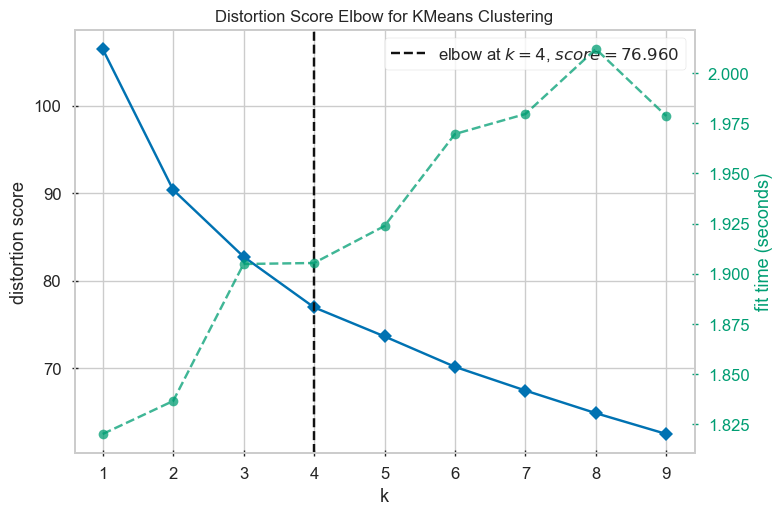

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9), k=(1, 10))

In [180]:
#Use the quick method and immediately show the figure
df = a_df_120
df_norm = df.div(df.median(axis=1), axis=0)
kelbow_visualizer(KMeans(), df_norm, k=(1,10))

N=5